In [1]:
# don't change this cell; just run it
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

# safe settings for Pandas
pd.set_option('mode.chained_assignment', 'raise')
%matplotlib inline
import matplotlib.pyplot as plt
from population_sample_image_generator import *

# make the plots look more fancy
plt.style.use('fivethirtyeight')

## Confidence intervals

- We will look at confidence intervals via a modern code-based method of generating them, called the bootsrap

- (I hope you'll agree!) this approach promotes a deep understanding of the meaning of confidence intervals 

- The information the confidence intervals convey is the same as that conveyed by confidence intervals generated by more traditional methods (e.g. those derived from formulas you have no doubt seen in statistics textbooks)

*Note*: This page has content from the [Bootstrap](https://github.com/data-8/textbook/blob/64b20f0/notebooks/Bootstrap.ipynb)
notebook of an older version of the [UC Berkeley data science course](https://inferentialthinking.com/). See the Berkeley course section of the [license file](https://uob-ds.github.io/cfd2021/license).

## A data scientist's predicament

Consider this scenario: a data scientist has been asked to help with a research project in the field of historical epidemiology - analysing historical datasets related to health. 

Her task is to calculate the average birthweight of babies born at a small hospital in Oakland, California in the year 1960. She is to do this in order to later test the hypothesis that babies born at this hospital in this year were underweight, relative to the national average at that time. (For now though, she is only interested in calculating the average birthweight at the hospital, in 1960).

However, the data scientist is in a predicament.  Initially, she was granted access to a random sample of 25 baby records whilst awaiting clearance from the hospital's medical records department to access the complete dataset. The complete dataset includes the birthweights for all 1236 babies born at that hospital in 1960.

But disaster has struck, and the hospital's medical records department has been subject to a ransomware attack, and so the full dataset is inaccessible, for a indeterminate period of time. (Alas, research rarely goes to plan!).

At the moment, she only has her random sample of 25 babies, which is shown the output of the code cell below:

In [2]:
# load in the sample data (this IS real data!)
babies_sample = pd.read_csv('babies_sample.csv')

# show the sample data
babies_sample

,birthweight_kg
0,3.260195
1,3.316894
2,2.806602
3,3.401942
4,3.033399
5,3.118447
6,3.373593
7,3.685438
8,3.628739
9,3.855535


Because our data scientist is interested in the average (mean) birthweight, so she calculates this from her sample:

In [3]:
# calculate the sample mean
sample_mean = babies_sample['birthweight_kg'].mean()

# show the sample mean
sample_mean

3.4121482272

She also plots the sample birthweights, to see how they are distributed, relative to the sample average:

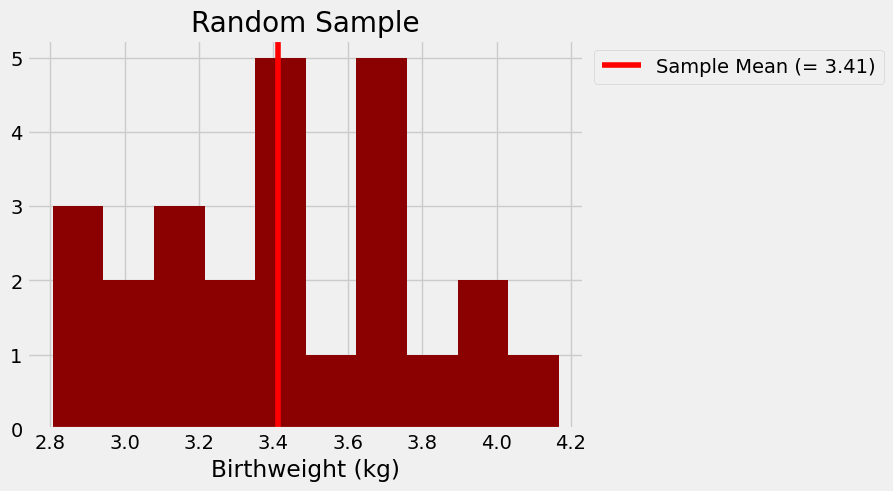

In [4]:
# plot the sample, and its mean
plt.hist(babies_sample['birthweight_kg'], color = 'darkred')
plt.axvline(sample_mean, color = 'red', label = f"Sample Mean (= {round(sample_mean, 2)})")
plt.xlabel('Birthweight (kg)')
plt.title('Random Sample')
plt.legend(bbox_to_anchor = (1,1));

Because the full dataset is inaccessible due to the ransomware attack, the random sample of 25 birthweights is the only evidence our data scientist has about mean birthweight in 1960. However, she doesn't care specifically about the mean birthweight of this random sample of 25 babies; *she cares about the mean birthweight of all 1236 babies born in 1960, at this particular hospital*. Let's refer to these 1236 babies as the *population* she is interested in.

Somehow she needs to use her sample and its average birthweight to accurately estimate the population's average birthweight.

It's important to clarify the terminology used I've used here. In statistics and data science, "population" refers to all the observational units (in this case, babies) that are of interest for a specific research question. In this case, the population of interest is all of the 1236 babies born at the hospital in 1960.

Conversely, a "sample" is a smaller subset of the population. A *random* sample is one where each observation in the sample had an equal probability of being selected, ensuring there is no bias towards specific observations. In this case, the sample being random means that each baby had an equal chance of being selected into the sample.

![](images/pop_sample_pic.png)

(image from: https://statsandr.com/blog/what-is-the-difference-between-population-and-sample/)

Our data scientist could simply take the average birthweight of her sample and report it as the estimated population birthweight, but she knows that her random sample is just one of many possible random samples. She knows that, on a different day, different babies' records would have made it into her random sample, and the sample's average birthweight would probably have been different. Consequently, if she were to use the sample average as her estimate of the population birthweight, her estimate would have been different as well.

Because she knows that her sample is just one of many samples she could have obtained, and that different random samples would probably have different average birthweights; she also knows that its unlikely her specific sample *perfectly* captures the population mean. Her sample is just one of many potential random samples - so why should she believe that her specific sample contains the best estimate of the population mean?

Because of these concerns, she is reluctant to use the sample mean *by itself* as an estimate of the population mean.

## An all-knowing perspective

Let's not just take our data scientist's word here though - let's use the power of code to empirically demonstrate the principles behind her concerns.

In order to do this I'd like you to imagine that WE (everyone present today) has access to the lost, full dataset. Let's imagine that there is a computer in the hospital which is not connected to the internet, and has survived the ransomware attack unscathed.

But only WE know the password to this hallowed computer, and so only WE can view the full dataset.

Here is the full dataset, containing the birthweights of all babies born in 1960 at the hospital:

In [5]:
# load in the population data
babies_pop = pd.read_csv('babies.csv')

# show the data
babies_pop

,birthweight_kg
0,3.401942
1,3.203496
2,3.628739
3,3.486991
4,3.061748
...,...
1231,3.203496
1232,3.628739
1233,3.685438
1234,3.543690


We are almost never in this situation in research - of being able to access the full population data - and so, from our luxury, all-knowing viewpoint, we can just plot the population data, and "peek" at the population mean:

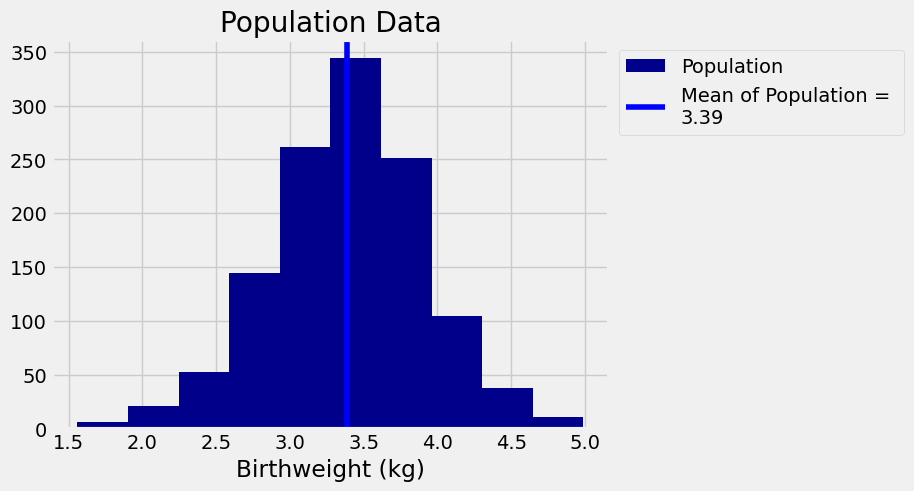

In [6]:
# plot a histogram, show the pop and pop mean
plt.hist(babies_pop["birthweight_kg"], color = 'darkblue', 
         label = 'Population')

# store the population mean as a variable
population_mean = babies_pop["birthweight_kg"].mean().round(2)

plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{population_mean}', 
            color = "blue")
# add axis labels and legend
plt.xlabel('Birthweight (kg)')
plt.legend(bbox_to_anchor = (1,1))
plt.title('Population Data');

From our seemingly all-knowing position of being able to "see" the full population data, we can simulate the situation the data scientist is in, by drawing a random sample of 25 babies from the population of 1236 babies. 

Further - because we have access to the population data - we can do this as many times as we like, so we can not only see how far off each sample average is from the actual population mean, we can also build an intuition as to how much sample averages vary as we draw lots of random samples.

The code cell below draws a random sample from the population data:

In [13]:
# draw a new sample
new_sample = babies_pop.sample(25)

# show the new sample and the mean
display(Markdown(f"\nNew sample mean = {np.mean(new_sample).round(2)}"))
display(new_sample.round(2))


New sample mean = 3.42

,birthweight_kg
1162,4.54
276,3.49
572,3.37
53,4.05
1081,3.35
781,3.18
757,4.39
823,4.00
489,3.35
131,2.86


From our omniscient perspective, let's draw another random sample and let's plot it against the population data, so we can see graphically how close or far our sample average is from the population average.

Through running this code cell multiple times, we can build an intuition for how much the sample averages vary, over repeated sample.

As we run the cell multiple times, let's evaluate how accurate it would be to use each single sample's mean as an estimate of the population mean - this will show us why our data scientist is reluctant to "trust" the mean of her single sample as an estimate of the population average:

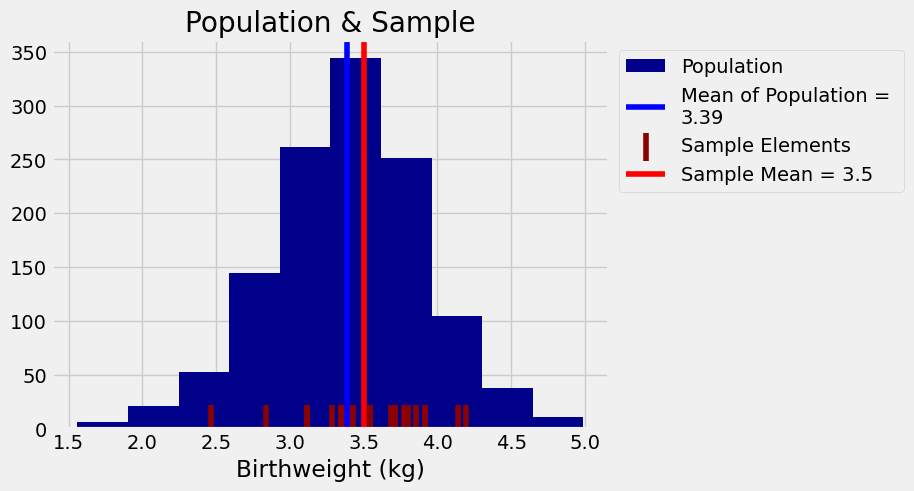

In [24]:
# draw a new random sample
sample = babies_pop["birthweight_kg"].sample(25)

# plot a histogram, show the pop and pop mean
plt.hist(babies_pop["birthweight_kg"], color = 'darkblue', 
         label = 'Population')
plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{population_mean}', 
            color = "blue")

# show the new sample and new sample mean
plt.scatter(sample, np.repeat(9, len(sample)), 
            marker = "|", s = 400, 
            color = 'darkred',
            label = 'Sample Elements')
plt.axvline(sample.mean(), color = "red",
            label = f'Sample Mean = {sample.mean().round(2)}')
    
# add axis labels and legend
plt.xlabel('Birthweight (kg)')
plt.legend(bbox_to_anchor = (1,1))
plt.title('Population & Sample');

We can see that from each sample, sometimes we get good estimates of the population mean, sometimes we get bad estimates.

Another way of showing this process is on which I like to call a "field plot" (just my name for it!). Imagine you're hovering in the sky, looking down on a field. In it are all the 1236 babies in the population are sitting in perfect lines (12 lines, with 103 babies in each). 

The graph below on the left shows these lines (viewed from above) and in the location of each baby, the birthweight of that baby is displayed. The graph on the left shows all of the birthweights for all 1236 babies.

The graph on the right shows a random sample of 25 of the baby birthweights (highlighted in red):

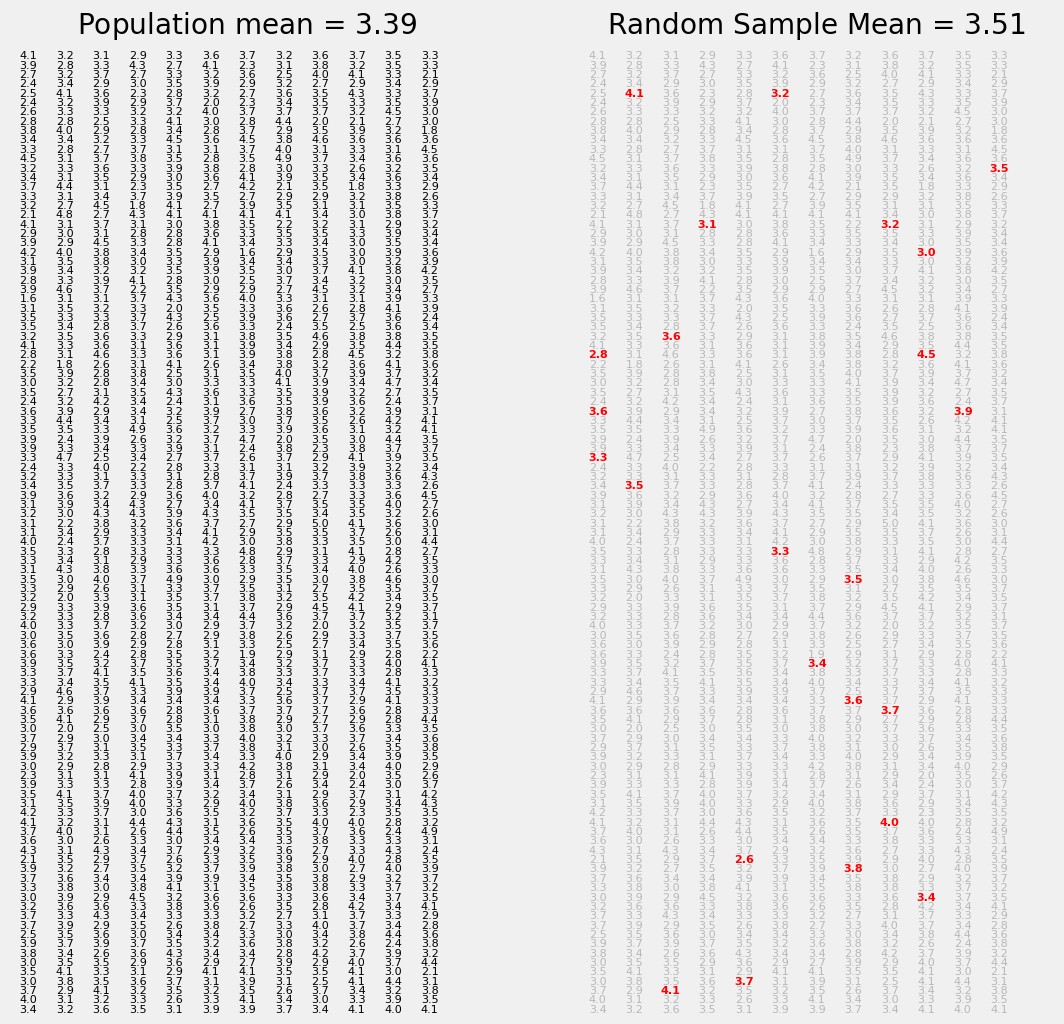

In [23]:
# this is a custom function, as the code to produce this plot is quite long...
field_plot(babies_pop, fontsize = 8, figsize = (12,12))

## Plus or minus a bit

I've just re-run several of the code cells above multiple times, each time drawing a new random sample from the population data.

It is important to remember that our data scientist is in the very limited position of essentially only having been able to run one of these cells once: she only has one random sample. She also cannot "see" the population data, so she must estimate the population mean from her sample data and sample mean.

But: we have seen that sample averages do not always capture the population average.

Sometimes sample averages are higher than the population mean, sometimes they are lower than the population mean.

Sometimes the deviation of the sample average from the population average is large, sometimes it is small.

This phenomenon is called *sampling error* - sample averages tend to deviate from the population average, even when the sample is random.

So when our data scientist is questioning whether her sample average is a good representation of the population average, she knows that the answer is "the population average is probably somewhere near my sample average, but because of sampling error the population average is going to be something like my sample average **plus or minus a bit**".

This "plus or minus a bit" here means her sample average is an *uncertain* estimate of the population average.

But how uncertain is her estimate? How does she know how big "plus or minus a bit" might be? Our data scientist is not in the luxury, all knowing perspective we are currently in. We can simply draw new random samples to see how much, on average, their means vary. We can also "peek" at the true population mean. Our data scientist cannot do either.

Currently, two things things are hidden from our data scientist:

- The population mean itself

- The amount by which sample means of different random samples vary from each other

If she knew the population mean, she wouldn't have to infer anything from her sample. She could just report the population mean to the rest of her reserch team, and proceed with the rest of the project.

But, even if she doesn't know the true population mean, if she knew the amount by which sample averages vary - over repeated random sampling of the sort we've just seen in the code cells above - she could use that information to construct an *interval* in which the population mean probably lies. 

Think of it this way: if our data scientist could draw many more random samples she could record the mean of each, and then see how much the means of random samples vary from each other. She knows that her first sample was also subject to this variability - if she then takes the "spread" of the sample averages, she can say "the population mean is probably my sample average, plus or minus the "spread" of the distribution of the sample averages, because that's how much variability there is when you draw repeated samples and calculate their means". 

This interval is a *confidence interval*. It gives us a precise estimate to how big "plus or minus a bit" it, when we say "the population mean is probably our sample mean, plus or minus a bit".

This might all sound a bit abstract. So let's convince ourselves it is true using code. Our data scientist can't draw new random samples from the population - but we from our luxury perspective can.

The code cell below repeats some code 1000 times. On each repeat, it draws a new random sample of 25 babies (just as in the code cells above). 

Each time a new sample is drawn, the mean of that sample is calculated. Once the code has run, we will have the means of 1000 random samples, drawn from the population data. This will tell us how much the means of random samples tend to vary from each other:

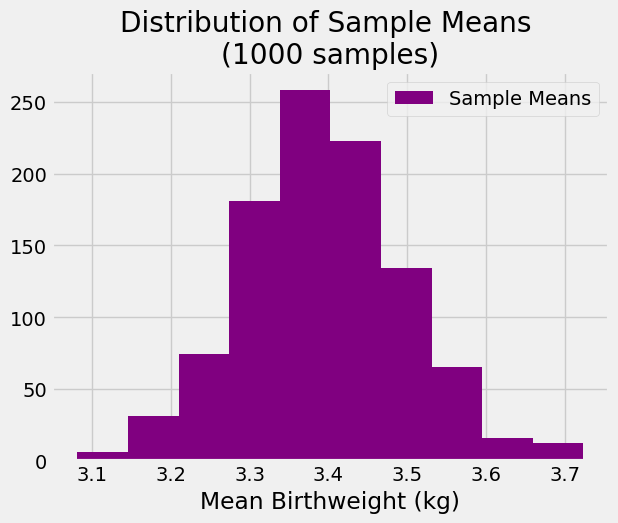

In [25]:
# set how many samples to draw
number_of_samples = 1000

# an empty array to store the sample means
sample_means = np.empty(number_of_samples)

# over 1000 repeats
for i in np.arange(1000):
    
    # draw a new random sample of 25 babies
    current_sample = babies_pop["birthweight_kg"].sample(25)
    
    # calculate and store the mean of the current sample
    sample_means[i] = current_sample.mean()

# plot the distribution of the sample means
plt.hist(sample_means, color = 'purple', label = 'Sample Means')
plt.legend(bbox_to_anchor = (1, 1))
plt.xlabel('Mean Birthweight (kg)')
plt.title(f'Distribution of Sample Means \n({number_of_samples} samples)');

Let's just recap what we've done here: because we have the population data, we've been able to draw repeated random samples from it.

We've drawn 1000 random samples, and calculated the mean for each one.

The purple histogram above shows the distribution of the means of these 1000 samples.

This histogram can let us quantify the "plus or minus a bit" mentioned above - because it shows us how much sample averages tend to vary from each other.

Now, if we take the "spread" of this sampling distribution, we can construct an interval which quantifies "plus or minus a bit". We'll follow convention here, and grab the middle 95% of the distribution:

In [26]:
# get the middle 95% of the distribution of sample means
left_interval, right_interval = np.percentile(sample_means, [2.5, 97.5])
print('Left:', left_interval)
print('Right:', right_interval)

Left: 3.1976841084000003
Right: 3.59942515632


We now have the middle 95% of the sample means, obtained via our all-knowing perspective of being able to repeatedly draw new samples and calculate their means:

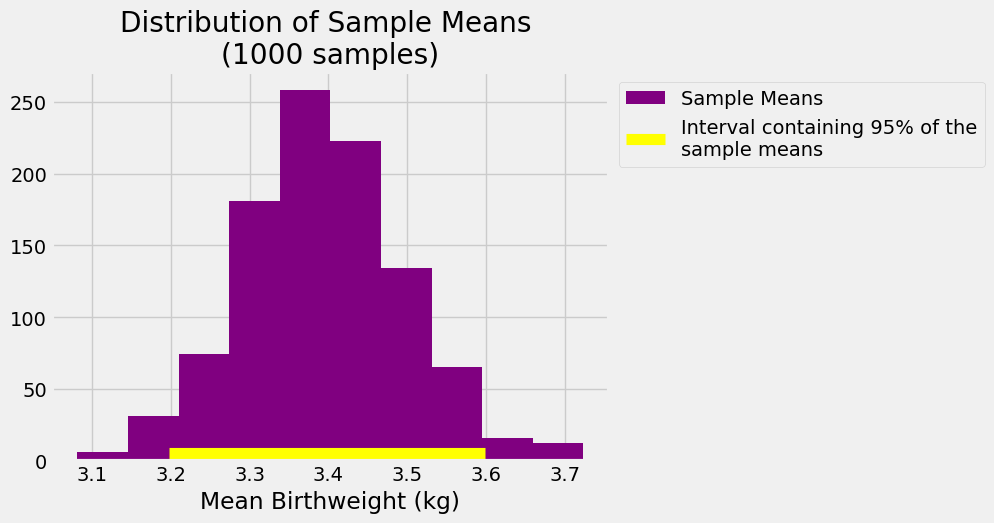

In [27]:
# plot the sampling distribution and the 95% interval
plt.hist(sample_means, color = 'purple', label = 'Sample Means')
plt.plot([left_interval, right_interval], [5, 5], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nsample means")
plt.legend(bbox_to_anchor = (1, 1))
plt.xlabel('Mean Birthweight (kg)')
plt.title(f'Distribution of Sample Means \n({number_of_samples} samples)');

Let's calculate how "wide" the interval is - that tells us precisely what "plus or minus a bit is", as it tells us how much the sample means typically vary from each other, as we draw lots of random samples:

In [28]:
# calculate the width of the interval
width_of_interval = right_interval - left_interval

# show the width of the interval
width_of_interval 

0.40174104791999987

What can we do with this interval?

The code cell below draws a new random sample and shows its mean.

It uses the "spread" of the sampling distribution - which we just calculated - and "places" the spread as an interval around the new sample mean.

If we re-run the cell lots of times, we can see that a very high proportion of the time, the yellow interval contains the population mean:

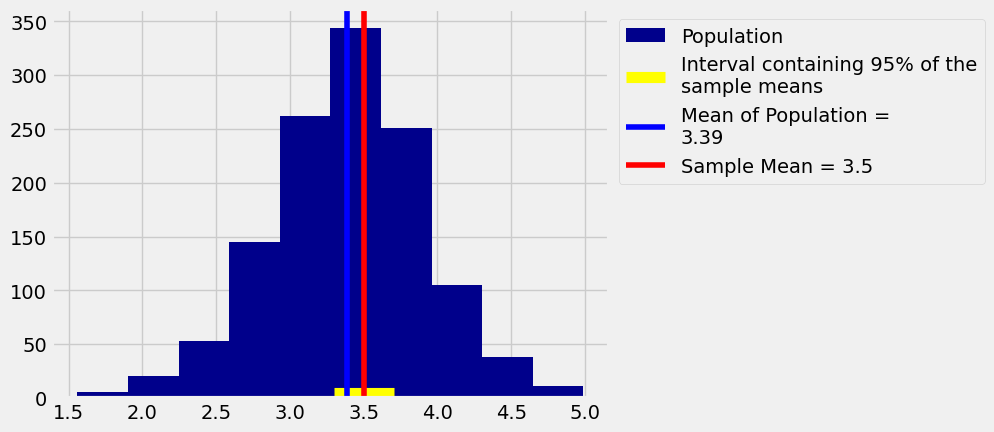

In [37]:
# draw a new random sample
sample = babies_pop["birthweight_kg"].sample(25)

# plot the population histogram
plt.hist(babies_pop["birthweight_kg"], color = 'darkblue', 
         label = 'Population')

# plot the confidence interval
plt.plot([sample.mean() - width_of_interval /2, sample.mean() + width_of_interval /2], [5, 5],
         color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nsample means")

# plot the population mean
plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{population_mean}', 
            color = "blue")

# plot the sample mean
plt.axvline(sample.mean(), color = "red",
            label = f'Sample Mean = {sample.mean().round(2)}')

plt.legend(bbox_to_anchor = (1, 1));

You can see that the interval we obtained from the sampling distribution contains the population mean a big proportion of the time, even when the sample mean deviates from the population mean.

**If our data scientist knew this interval - even if she doesn't know the population mean - she could present this interval alongside her sample mean, and tell her colleagues: "the population mean is probably within this interval around my sample mean".**

The cell below repeats the code from the cell above 100 times (apart from plotting the graphs!), and it shows the proportion of times over all 1000 repeats that the interval around the sample mean contained the population mean.

In [43]:
# set the number of repeats
number_of_repeats = 100

# an empty array, to record whether the interval contained
# the population mean, on each repeat
contains_population_mean = np.empty(number_of_repeats)

# empty arrays to store in the intervals themselves
left_intervals = np.empty(number_of_repeats)
right_intervals = np.empty(number_of_repeats)

# empty array to store the mean of each sample
one_hundred_sample_means = np.empty(number_of_repeats)

# on each repeat...
for i in np.arange(number_of_repeats):
    
    # draw a new sample
    current_sample = babies_pop["birthweight_kg"].sample(25)
    
    # store the sample mean
    one_hundred_sample_means[i] = current_sample.mean()
    
    # calculate the confidence interval, from the spread of the sampling 
    # distribution
    left_end_of_interval = current_sample.mean() - width_of_interval /2
    right_end_of_interval = current_sample.mean() + width_of_interval /2
    
    # store the intervals
    left_intervals[i] = left_end_of_interval 
    right_intervals[i] = right_end_of_interval
    
    # work out if the interval contains the population mean
    contains_population_mean[i] = np.logical_and(left_end_of_interval < population_mean, right_end_of_interval > population_mean)
    
# display the percentage of repeats where the interval contained the population mean
display(Markdown(f"First, we drew 1000 random samples from the population, and plotted a histogram of their means."))
display(Markdown(f"Then we calculated the interval 'picking out' the middle 95% of that distribution of means."))
display(Markdown(f"{number_of_repeats} new random samples have been drawn."))
display(Markdown(f"For each sample, the sample mean has been calculated. And we have 'placed' the interval over each sample mean."))
display(Markdown(f"<b>{sum(contains_population_mean)/number_of_repeats * 100}% of the intervals contained the population mean.</b>"))

First, we drew 1000 random samples from the population, and plotted a histogram of their means.

Then we calculated the interval 'picking out' the middle 95% of that distribution of means.

100 new random samples have been drawn.

For each sample, the sample mean has been calculated. And we have 'placed' the interval over each sample mean.

<b>94.0% of the intervals contained the population mean.</b>

We can also demonstrate this graphically - the plot below shows the 100 confidence intervals generated by the code cell above:

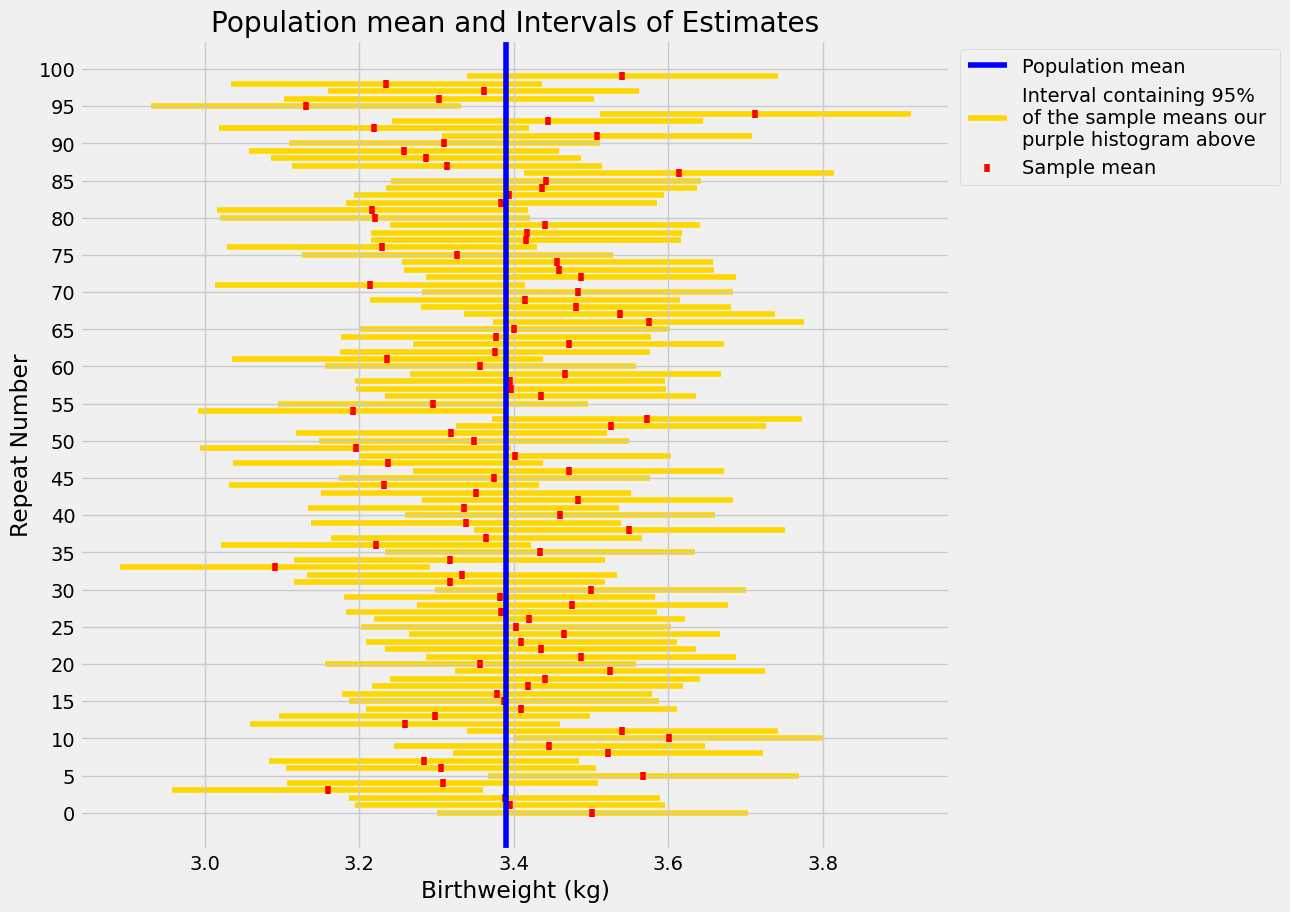

In [44]:
# set the figure size
plt.figure(figsize=(10,10))

# make a dataframe of confidence intervals, from the 100 repeats
intervals = pd.DataFrame({'Left': left_intervals,
                         'Right': right_intervals})

# plot each sample mean, in the centre of the interval
for i in np.arange(len(intervals)):
    ends = intervals[['Left', 'Right']].iloc[i]
    plt.plot(ends, [i, i], color='gold', zorder=0)
    plt.scatter(one_hundred_sample_means[i], i,
                color='red', marker = "|")

# plot the population mean and add graph labels
plt.axvline(population_mean,  color='blue', label = 'Population mean')
plt.plot([], [], color = 'gold',
         label = "Interval containing 95% \nof the sample means our \npurple histogram above")
plt.scatter([], [], color='red', marker = "|", label = "Sample mean")
plt.xlabel('Birthweight (kg)')
plt.ylabel('Repeat Number')
plt.yticks(np.arange(0, len(intervals)+1, 5))
plt.title('Population mean and Intervals of Estimates')
plt.legend(bbox_to_anchor = (1, 1));

This is meaning of a confidence interval - over repeated random samples drawn from the population, the interval will contain the population mean around 95% of the time.

Even if our data scientist didn't know the population mean, if she has access to this interval, she could present it alongside her sample mean and confidently inform her colleagues that the population mean is likely within this interval, centered around her sample mean.

*But* - and this is a huge but - we obtained our confidence interval here only because we are in the godlike position of being able to access the whole population data, and so we were able to build our confidence interval by repeatedly drawing random samples from the population. This told us how much the means of random samples typically vary from each other, and we used that spread to construct our confidence interval.

Our data scientist cannot do this - she cannot draw new random samples from the population data she cannot access. So what is she to do?

# The Bootstrap

Our data scientists is in the situation a person in research is typically in: she doesn't have access to the population data, and she cannot simply draw more random samples from the population. She's limited to the one sample she has. 

Somehow, to build a confidence interval, she has to get lots of new random samples without being able to draw any new random samples from the population. This seems like an impossible situation.

Fortunately, a brilliant idea called the bootstrap can help her out here. The bootstrap let's us simulate drawing new random samples by a method called *resampling*: the new samples are drawn at random *from the original sample*. This can allow us to build confidence intervals like we've just seen: **but we do not need access to the population data in order to this, we just need our single, random sample**.

This may seem like a sleight of hand, but hopefully I can convince you it works!

We will now see how and why the bootstrap works. Let's first remind ourselves what the data scientists single random sample looks like:

In [45]:
# show the data scientist's sample
babies_sample

,birthweight_kg
0,3.260195
1,3.316894
2,2.806602
3,3.401942
4,3.033399
5,3.118447
6,3.373593
7,3.685438
8,3.628739
9,3.855535


## The Bootstrap: resampling from the sample

Here are the steps of *the bootstrap method* for simulating the process of drawing new random
samples from the population:

- **Treat the original sample as if it were the population.**
- **Draw from the sample -the same size as the original sample -**, at random **with** replacement.

So let's just break that down: to get our new sample - I'll refer to this as a "bootstrap resample" - we select a baby at random from our original sample and record their birthweight. We then put that baby's record back in with the other records in the sample and then draw again at random. We do this until we have a new sample of 25 birthweights.

It is important that the bootstrap resample is the same size as the original sample
size. Since our original sample consisted of 25 babies, our sample
mean was based on 25 babies. To see how different the sample mean could have
been, we have to compare it to the mean of other samples of size 25.

#### Why do we resample WITH replacement?

If we drew 25 times at random *without* replacement from our sample of size
25, we would just get the same sample back. By drawing *with* replacement, we
create the possibility for the new samples to be different from the original,
because some employees might be drawn more than once and others not at all.

Why is this a good idea? On average, **random samples tend to resemble the population...so random bootstrap resamples of the sample tend to resemble the population as well**. This entails that when we generate bootstrap resamples and calculate their means, these means provide pretty good estimates of the population mean. They also provide pretty good estimates of how much the means of random samples tend to vary from each other (and this is in the information we need to build our confidence interval!).

![](images/bootstrap_pic.png)

## A resampled mean

To get a bootstrap resample, we want a sample the same size as the original sample (25 babies), where we are
sampling *with replacement*. 

Here is one new sample drawn from the original sample, with replacement, and
the corresponding sample mean.

New bootstrap resample:

,birthweight_kg
22,2.806602
2,2.806602
6,3.373593
19,3.940583
10,2.920001
4,3.033399
11,3.118447
9,3.855535
18,2.948350
6,3.373593


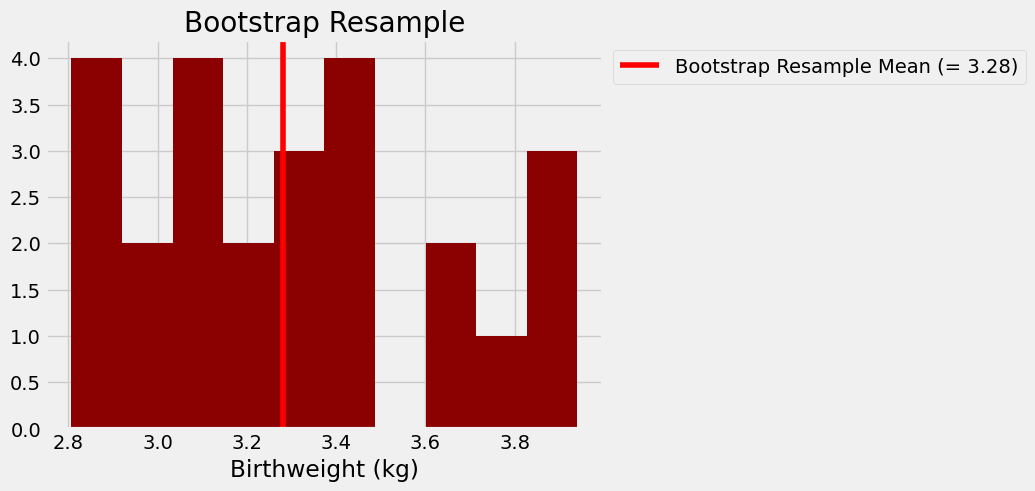

In [48]:
# draw a sample of size 25 from our original sample, with replacement.
bootstrap_resample = babies_sample['birthweight_kg'].sample(25, replace= True)

# show the sample
display(Markdown("New bootstrap resample:"))
display(pd.DataFrame({'birthweight_kg': bootstrap_resample}))

# plot a histogram of the sample
plt.hist(bootstrap_resample, color = 'darkred')
plt.axvline(bootstrap_resample.mean().round(2),
            color = 'red',
            label = f"Bootstrap Resample Mean (= {bootstrap_resample.mean().round(2)})")
plt.xlabel('Birthweight (kg)')
plt.title('Bootstrap Resample')
plt.legend(bbox_to_anchor = (1,1));

Each time we resample, we generate something like a new sample mean with which estimate of the population
mean. By resampling again and again, we will get many such new sample means, allowing us to build
a distribution of sample means. 

This tells us how much sample means are likely to vary from each other as we draw repeated new random samples, and this information can be used to build a confidence interval. **But** this time we aren't drawing any new samples from the population data - e.g. we aren't relying on our rare and luxury perspective - in order to generate this distribution of sample means. We are "bootstrapping" this distribution from the one random sample we have. This technique is available to our data scientist, using just the one sample she has!

## A distribution of means from bootstrap resamples

Let us define a function `bootstrap_mean` that takes our original sample,
and the number of bootstrap samples we want to take, and returns an array of
the corresponding bootstrap resample means.

In [50]:
def bootstrap_mean(original_sample, number_of_bootstrap_resamples):
    """Return array of bootstrapped sample means

    Parameters
    ----------
    original_sample: Series containing the original sample
    number_of_bootstrap_resamples: number of bootstrap resamples
    to perform

    Returns
    -------
    resampled_means : Array of bootstrapped sample means.
    """
    # calculate the length of the original sample
    n = len(original_sample)
    
    # create an empty array to store the estimate of the means
    # over repeated resamples
    resampled_means = np.zeros(number_of_bootstrap_resamples)

    # repeat the resampling procedure, and store the estimate of
    # the mean each time
    for i in np.arange(number_of_bootstrap_resamples):
        bootstrap_sample = original_sample.sample(n, replace=True)
        resampled_means[i] = np.mean(bootstrap_sample)
        
    # return the array of estimate means
    return resampled_means

We now repeat the bootstrap process 1000 times. The array `bstrap_means`
contains the means of all 1000 bootstrap samples. Notice that the code
takes longer to run than our previous code. It has a lot of resampling to do!

In [51]:
# set the number of bootstrap resamples we want to generate
number_of_bootstrap_resamples = 1000

# run our function, to generate an array containing the bootstrapped means
bootstrap_sample_means = bootstrap_mean(babies_sample['birthweight_kg'], number_of_bootstrap_resamples)

# show the array
bootstrap_sample_means

array([3.32596569, 3.47678513, 3.5142065 , 3.5493599 , 3.44843561,
       3.41328221, 3.42348804, 3.51307252, 3.5493599 , 3.3962725 ,
       3.27153461, 3.5493599 , 3.33503753, 3.45637348, 3.35658317,
       3.44956959, 3.41101425, 3.45750746, 3.37359288, 3.31575986,
       3.44389969, 3.43369386, 3.41895211, 3.43482784, 3.43029192,
       3.5085366 , 3.41328221, 3.3962725 , 3.48925892, 3.50967058,
       3.43369386, 3.44276571, 3.42235405, 3.24545305, 3.47565115,
       3.51307252, 3.40534434, 3.44843561, 3.42122007, 3.33050161,
       3.27493655, 3.48018708, 3.31008996, 3.39967444, 3.49606281,
       3.37699482, 3.46884727, 3.31008996, 3.42915794, 3.4314259 ,
       3.35998511, 3.42348804, 3.48585698, 3.38153075, 3.49266086,
       3.49266086, 3.40874628, 3.51874242, 3.47905309, 3.46544532,
       3.32369772, 3.43482784, 3.46204338, 3.47678513, 3.41101425,
       3.52327835, 3.37132492, 3.35658317, 3.37132492, 3.41668415,
       3.39513852, 3.34070744, 3.38946861, 3.43936377, 3.44956

After running this function, we now have the we have the means from 1000 simulated samples.

**But we've gotten them all from our original random sample of 25 babies - we haven't touched the population data.**

In [52]:
# show that we have the means from 1000 simulated samples
len(bootstrap_sample_means)

1000

Here is the histogram of the 1000 means from the bootstrap resamples; this gives us an estimate of how much sample means (from samples of size 25) tend to vary from each other:

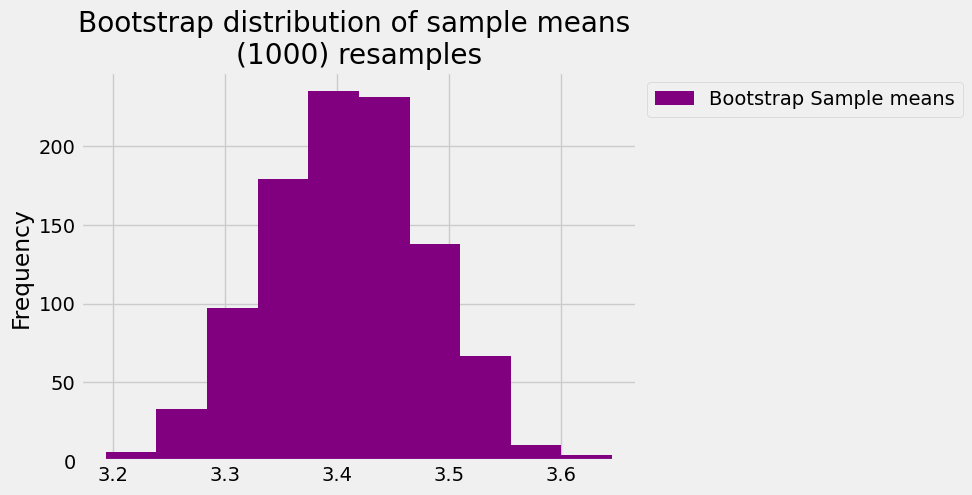

In [54]:
# a new dataframe for the means, obtained via resampling
resampled_means = pd.DataFrame()
resampled_means['Bootstrap Sample means'] = bootstrap_sample_means

# plot the distribution of bootstrapped means
resampled_means.plot.hist(color = 'purple')

# add title and labels to the plot
plt.title(f'Bootstrap distribution of sample means \n({number_of_bootstrap_resamples}) resamples')
plt.legend(bbox_to_anchor = (1, 1));

## Building a bootstrap confidence interval

Just to recap: earlier we used our "all-knowing" perspective to draw 1000 random samples directly from the population data. We then used the distribution of the means of those samples to build a confidence interval (using the width of the interval covering the middle 95% of the sample means.

Well, now we've done something very similar through the bootstrap resampling - only we've done it from a single random sample, without accessing the population data.

We can construct an interval the same way as before:

In [55]:
left, right = np.percentile(bootstrap_sample_means, [2.5, 97.5])
print('Left:', left)
print('Right:', right)

Left: 3.271534608
Right: 3.5482259232


We show the interval on the histogram of boostrap resample means:

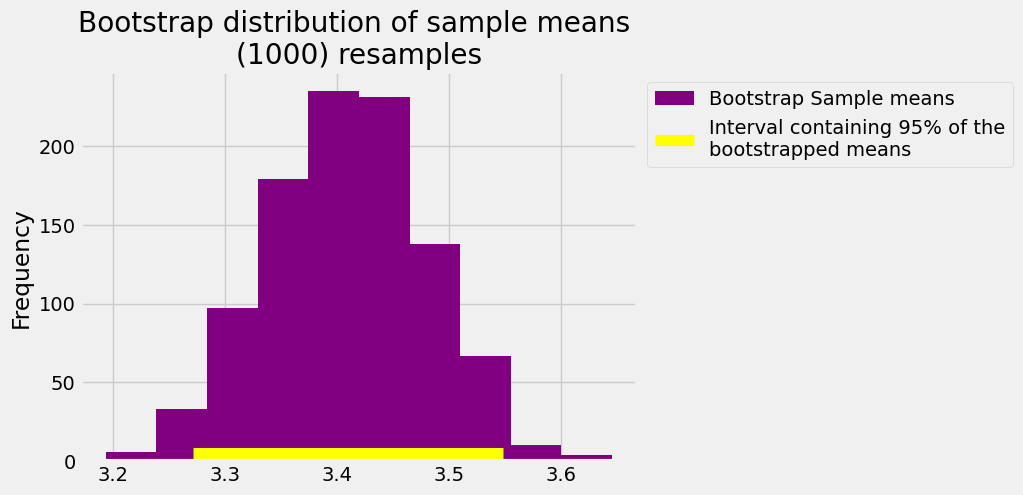

In [57]:
# show the boostrap resample distribution, its middle 95%, and the population mean
resampled_means.plot.hist(color = 'purple')
plt.plot([left, right], [5, 5], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nbootstrapped means")
plt.title(f'Bootstrap distribution of sample means \n({number_of_bootstrap_resamples}) resamples')
plt.legend(bbox_to_anchor = (1, 1));

Remember the confidence intervals we generated from our all-knowing perspective?
We demonstrated through [....] that these captured the population mean around 95% of the time

Do the boostrap confidence intervals perform as well? [Remember that the bootstrap ones don't need all knowing perspective]

The cell blow does [....]

<b>LINE 16 NEEDS AMENDING - set up "re-run the tape scenario".</b>

We can run this cell manually many times to get a feel for how often the bootstrapped confidence intervals capture the population mean:

In [ ]:
# One trial, generating a left and right interval.
# Take a new sample.
this_sample = babies_sample['birthweight_kg'].sample(25, replace=True)

# Get the bootstrap sampling distribution of the mean.
these_means = pd.Series(bootstrap_mean(this_sample, number_of_bootstrap_resamples))

these_means.plot.hist(color = 'purple', label = "Boostrap Sample means")
plt.axvline(population_mean,  color='blue', label = 'Population mean')

# Calculate the left, right ends, and plot them.
left_end, right_end = np.percentile(these_means, [2.5, 97.5])
plt.plot([left_end, right_end], [0, 0], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nbootstrapped means")

# add plot labels
plt.show()

# show the left and right end values
print('Left', left_end)
print('Left', right_end)

Let's use some python looping to re-run this process 20 times [in order to]...

In [ ]:
# THE BIG SIMULATION: this one can take a minute or two

# set up to make 20 left and right intervals
n_intervals = 100
left_ends = np.zeros(n_intervals)
right_ends = np.zeros(n_intervals)

for i in np.arange(n_intervals):
    
    if i in np.arange(0, 101, 10):
        display(Markdown(f"{i}/{n_intervals} completed."))
    
    # one trial, generating a left and right interval
    
    # take a new sample.
    this_sample = babies_sample['birthweight_kg'].sample(25, replace=True)
    
    # get the distribution of bootstrap resample means
    these_means = bootstrap_mean(this_sample, number_of_bootstrap_resamples)
    
    # calculate the left, right ends
    left_end, right_end = np.percentile(these_means, [2.5, 97.5])
    
    # store the results for this trial
    left_ends[i] = left_end
    right_ends[i] = right_end

# show when done
display(Markdown(f"Completed!"))

# put interval ends into own data frame.
intervals = pd.DataFrame()
intervals['Left'] = left_ends
intervals['Right'] = right_ends

For each of the 20 repeats, we get one (left, right) interval of
estimates of the mean.

In [ ]:
# show the sample interval
intervals

The good intervals are those that contain the population mean, which we are trying to
estimate. Typically the parameter is unknown, but again, from our luxury, all-knowing perspective we happen to
know what the population mean is.

In [ ]:
population_mean

How many of the 20 intervals contain the population mean? That's the number
of intervals where the left end is below the population mean and the right
end is above.

In [ ]:
intervals["Contains Population mean"] = np.logical_and(left_ends < population_mean, right_ends > population_mean)
intervals

What percentage of the intervals contain the population mean?

In [ ]:
contains_population_mean_resample_intervals = np.logical_and(left_ends < population_mean, right_ends > population_mean)

display(Markdown(f"{sum(contains_population_mean_resample_intervals)/len(intervals) * 100}% of the intervals contained the population mean."))

[We can show this graphically]

In [ ]:
plt.figure(figsize=(8,8))
for i in np.arange(len(intervals)):
    ends = intervals[['Left', 'Right']].iloc[i]
    plt.plot(ends, [i, i], color='gold')
plt.axvline(population_mean,  color='blue', label = 'Population mean')
plt.plot([], [], color = 'gold',
         label = "Intervals containing 95% of the\nbootstrapped means for a given repeat")
plt.ylabel('Repeat Number')
plt.yticks(np.arange(0, n_intervals+1, 5))
plt.xlabel('Birthweight (kg)')
plt.title('Population mean and Intervals of Estimates');
plt.axvline(sample_mean, color = 'red', label = f"Sample Mean (= {round(sample_mean, 2)})");

<b> NOTE: </b> set up a "run the tape back scenario" - we want to know how good this procedure is for capturing the population mean.

Data scientist is given the random sample of 25, does the bootstrap....we "re-run the tape of reality"...how many times does her interval contain the population mean.

Let's summarize the process of generating bootstrap confidence intervals:

* (Like our data scientist) you have one random sample from a population. You want to estimate the population mean.
* You bootstrap your random sample, to get a bootstrap resample. You calculate the mean of your boostrap resample.
* You repeat the above step thousands of times, and get thousands of bootstrap resample means.
* You pick off the "middle 95%" of the bootstrap sample means.

That gives you one interval of estimates in which the population mean probably lies.

In fact, if you repeat this *whole process* many times (e.g. generating a new confidence interval each time), then 95% of those confidence intervals will likely contain the population mean.

## Summary

[If we are in a godlike perspective, we can construct confidence intervals by...]

[It we are in the typical perspective, the one our data scientist is in, we can construct confidence intervals we can]

*Note*: This page has content from the [Bootstrap](https://github.com/data-8/textbook/blob/64b20f0/notebooks/Bootstrap.ipynb)
notebook of an older version of the [UC Berkeley data science course](https://inferentialthinking.com/). See the Berkeley course section of the [license file](https://uob-ds.github.io/cfd2021/license).